In [37]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#sklearn - Machine Learning Package
import sklearn.model_selection as modsel
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

#statsmodels - traditional statistical modeling package
import statsmodels.api as sm

import cPickle as pickle

### Load & Inspect Data

In [38]:
filename = 'block_1.csv'
DT = pd.read_csv(filename,na_values='?')

####
# Data Inspection
# - Total Number of Records and Features
# - Unique Feature Data Types
# - Presence of Null Entries
####

print('Dimensions: %s records x %s features.' % DT.shape)

print('Unique Feature Data Types: %s' % len(DT.dtypes.unique()))
for x in DT.dtypes.unique():
    print(' -> '+str(x))

null_idx = DT.isnull().any().values
null_idx = null_idx[null_idx==True]
print('')
print('NULL Entries: %s ' % len(null_idx))

if len(null_idx>0):
    DT =DT.fillna(value = -1)
    print('NULL Entries Set To %s' % (-1))

#if(len(null_idx)>0):
#    for x in null_idx:
#        if(DT.iloc[:,x].isnull()):
#            print(' - ' + str(x) + ' has %s NULL entries' % len(DT[x].isnull()))
#del null_idx

print(DT.info())

Dimensions: 574913 records x 12 features.
Unique Feature Data Types: 3
 -> int64
 -> float64
 -> bool

NULL Entries: 7 
NULL Entries Set To -1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574913 entries, 0 to 574912
Data columns (total 12 columns):
id_1            574913 non-null int64
id_2            574913 non-null int64
cmp_fname_c1    574913 non-null float64
cmp_fname_c2    574913 non-null float64
cmp_lname_c1    574913 non-null float64
cmp_lname_c2    574913 non-null float64
cmp_sex         574913 non-null int64
cmp_bd          574913 non-null float64
cmp_bm          574913 non-null float64
cmp_by          574913 non-null float64
cmp_plz         574913 non-null float64
is_match        574913 non-null bool
dtypes: bool(1), float64(8), int64(3)
memory usage: 48.8 MB
None


### Split Data into Training and Test Sets

In [47]:
#Proportion of Data Used for Test Set
prop_test = 0.2

cols = ['cmp_fname_c1','cmp_fname_c2', 'cmp_lname_c1', 'cmp_lname_c2',
              'cmp_bd', 'cmp_bm', 'cmp_by', 'cmp_plz']

str_output = 'is_match'

#Create Train & Test Sets
X_train, X_test, y_train, y_test = modsel.train_test_split( DT[cols],
                                                            DT[str_output],
                                                            test_size=prop_test, 
                                                            random_state=1234)
X_train = sm.add_constant(X_train,prepend=False)
X_test = sm.add_constant(X_test,prepend=False)

### Initialize & Train Model Objects

In [52]:
# Traditional Logit Model
np.random.seed(1234)
model_logit = sm.GLM( y_train,X_train,family=sm.families.Binomial())
model_logit=model_logit.fit()

print(model_logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_match   No. Observations:               459930
Model:                            GLM   Df Residuals:                   459921
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -49.412
Date:                Thu, 22 Jun 2017   Deviance:                       98.825
Time:                        10:05:54   Pearson chi2:                 1.14e+06
No. Iterations:                    16                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cmp_fname_c1     6.2225      0.840      7.409      0.000       4.576       7.869
cmp_fname_c2     0.1051      1.732      0.061 

### Test Set Model Validation - AUC

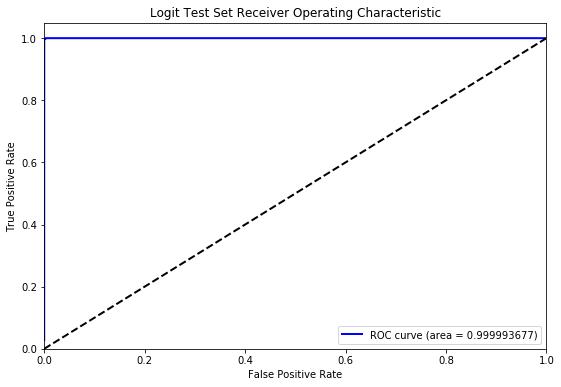

In [53]:
test_probs = model_logit.predict(X_test)

#Calculate FPR and TPR for Difference Thresholds
fpr, tpr,thresh = metrics.roc_curve(y_true=y_test,y_score = test_probs)

#Calculate AUC for ROC
auc = metrics.roc_auc_score(y_true=y_test,y_score = test_probs)

plt.figure(figsize=(9,6))
plt.plot(fpr, tpr, lw=2,color='blue', label='ROC curve (area = %0.9f)' % auc)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logit Test Set Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Save Model

In [54]:
logit_file = 'UCI_logit_model_rebuild.pkl'
pickle.dump(model_logit,open(logit_file, "wb"))